In [1]:
%matplotlib notebook

# Iris/dask dataset loading investigation

## Introduction

This demos using dask functionality beyond the `array` module to help with Iris processing. Specifically, in this notebook we will demo alternative approaches for loading numerous and/or large datasets into Iris.

Three approaches will be compared:

* The standard Iris load
* Wrapping Iris load calls in a **dask bag** generated from a sequence
* Wrapping Iris load calls in a **dask bag** generated from a **delayed** call

These options will be compared with two simple metrics:

- Ease of use
- Runtime

## Setup

Below are the functions used to load the dataset. There is one function for each of the standard Iris load and the bag generated from a sequence. The bag generated from a delayed call requires two functions; one which is delayed, one to call the delayed function.

### Imports

In [2]:
import os
import time

import dask.bag as db
import dask.delayed as delayed
import iris

In [3]:
print iris

<module 'iris' from '/opt/scitools/environments/default/2018_01_19/lib/python2.7/site-packages/iris/__init__.py'>


### Timer function

A simple function that records the runtime of a supplied function. This will be useful for capturing results; otherwise within this notebook we can just make use of the `%timeit` magic. 

In [4]:
def timer(func, *funcargs):
    t0 = time.time()
    func(*funcargs)
    t1 = time.time()
    return t1 - t0

def repeater(repeat, *timerargs):
    if repeat <= 1:
        result = timer(*timerargs)
    else:
        result = [timer(*timerargs) for _ in range(repeat)]
    return result

### Runner functions

#### Functions that make a result

In [5]:
def direct_load(fp, pattern):
    """Load datasets at the filepath `fp` using Iris."""
    iris.load(os.path.join(fp, pattern))

def withbag(fp, seq):
    """
    Load a number of individual datasets in a sequence using Iris.
    
    This is a little more complex as we need to generate a sequence and map
    that sequence onto a load call. The dask bag is generated from that
    sequence.

    """
    loader = lambda fn: iris.load_cube(os.path.join(fp, fn))
    cs = db.from_sequence(seq).map(loader)
    iris.cube.CubeList(cs.compute())

# @delayed
# def delay(fp):
#     """
#     A simple Iris load function decorated with dask's `delayed` functionality.
    
#     TODO: could this be done as `delayed(direct_load)` instead?
#     """
#     return iris.load(os.path.join(fp, '*.nc'))

# def delay_wrapper(fp):
#     """Converts the delay-wrapped function into a dask bag."""
#     dlyd = delay(fp)
#     cs = db.from_delayed(dlyd)
#     iris.cube.CubeList(cs.compute())

def delay_wrapper_v2(fp, pattern):
    dlyd = delayed(direct_load(fp, pattern))
    cs = db.from_delayed(dlyd)
    iris.cube.CubeList(cs.compute())

## Test!

Run each loader on some sample data and print the output.

Using **sample NetCDF data** at `/project/applied/OECD/data/original_data/tas/rcp26`:

In [6]:
fp = '/project/applied/OECD/data/original_data/tas/rcp26'
seq = os.listdir(fp)

In [7]:
# %timeit direct_load(fp)

In [8]:
# %timeit withbag(fp, seq)

In [9]:
# %timeit delay_wrapper(fp)

### Digging deeper

The `%timeit` magic is useful for giving a quick overview of how long something is taking. Now let's look a little more deeply by using some box and whisker plots showing the runtime.

In [10]:
reps = 10

In [11]:
direct_load_vals = repeater(reps, direct_load, fp, '*.nc')
with_bag_vals = repeater(reps, withbag, fp, seq)
# delay_vals = repeater(reps, delay_wrapper, fp)
delay_vals_v2 = repeater(reps, delay_wrapper_v2, fp, '*.nc')

In [12]:
print direct_load_vals
print delay_vals_v2

[9.205405950546265, 1.2533559799194336, 0.7181210517883301, 0.8158400058746338, 0.7299239635467529, 0.7193498611450195, 0.7494158744812012, 0.7299120426177979, 0.7661678791046143, 0.7400028705596924]
[0.7362298965454102, 0.7842988967895508, 0.762505054473877, 0.7650690078735352, 0.7440969944000244, 0.734227180480957, 0.7690479755401611, 0.7502081394195557, 0.7429201602935791, 0.7470262050628662]


#### Plot the results

In [13]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


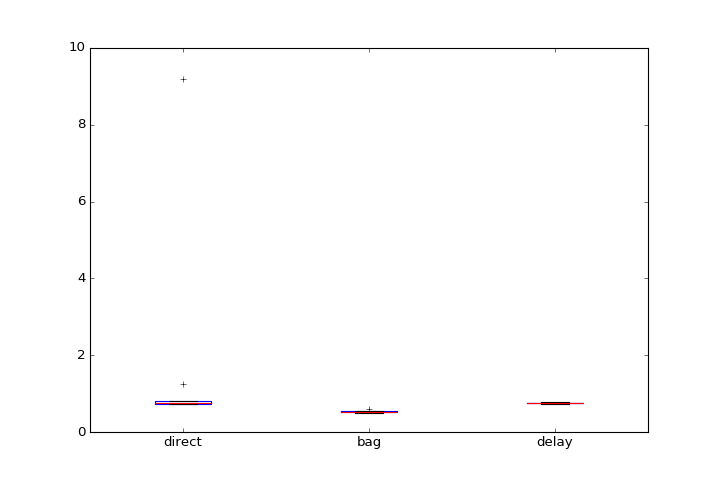

In [14]:
fig = plt.figure(figsize=(9, 6))
plt.boxplot([direct_load_vals, with_bag_vals, delay_vals_v2],
            vert=True, labels=['direct', 'bag', 'delay'])
plt.show()

### Different dataset

In [15]:
fp = '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z'
fn = 'EURO4_2015060[1-3].pp'
seq = os.listdir(fp)
reps = 3

In [16]:
direct_load_vals_pp = repeater(reps, direct_load, fp, fn)
# with_bag_vals_pp = repeater(reps, withbag, fp, seq)
delay_vals_v2_pp = repeater(reps, delay_wrapper_v2, fp, fn)

<IPython.core.display.Javascript object>


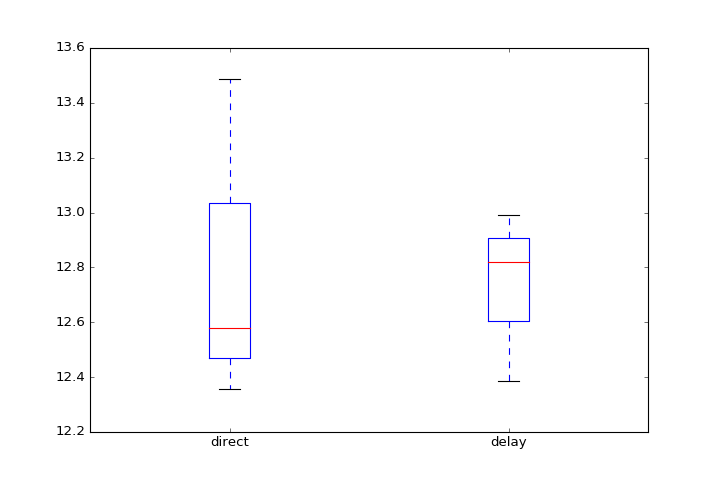

In [17]:
fig = plt.figure(figsize=(9, 6))
plt.boxplot([direct_load_vals_pp, delay_vals_v2_pp],
            vert=True, labels=['direct', 'delay'])
plt.show()